### RetinaFace for Input Model ArcFace

#### Deteksi Wajah Tiap Folder dan Subfolder Train, Val dan Test

1.) fungsi extract_face untuk mekstraksi wajah dan mengubah dataset menjadi gambar wajah saja mengubah ukuran gambar sesuai input model face net 160 x 160 /arc face 112 x 112

2.) load faces untuk meload gambar menjadi dari direktori yang diinput kemudian melakuak ekstraksi wajah dari folder train test val

3.) load_dataset mengammbil direktori train , test dan val kemudian dilakukan deteksi wajah untuk setiap subdirektori dari identitas wajah essex faces 

In [2]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
from mtcnn.mtcnn import MTCNN
import tensorflow as tf
from terran.io import open_image
from terran.vis import display_image, vis_faces
from terran.face import face_detection

# configuration = tf.compat.v1.ConfigProto()
# configuration.gpu_options.allow_growth = True
# session = tf.compat.v1.Session(config=configuration)
# extract a single face from a given photograph
#160, 160
from timeit import default_timer as timer
start = timer()
def extract_face(filename, required_size=(112, 112)): #face net 160 x 160 /arc face 112 x 112
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	#print(image)
	# convert to array
	image_w, image_h = image.size
	pixels = asarray(image)
	# create the detector, using default weights
	# detect faces in the image
	#using retinaface
	detector = face_detection(pixels)
	results = detector

	#using MTCNN
	# detector = MTCNN()
	# results = detector.detect_faces(pixels)
	
	if(len(results) == 0): 
		return []
	else:
		# extract the bounding box from the first face
		x1, y1, width, height = results[0]['bbox']
		image = image.crop((x1,y1,width,height))
		image = image.resize(required_size)
		face_array = asarray(image)
		return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		#print(path)
		# get face
		face = extract_face(path)
		#print('problem check 2')
		if(len(face) == 0):
			continue
		# store
		faces.append(face)
		#print('problem check 3')
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		#print(subdir)
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		#print('problem check 4')
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
		#print('problem check 5')
	return asarray(X), asarray(y)

# load train dataset
#detector = MTCNN()

trainX, trainy = load_dataset('dataset/faces96/result/train/')

# load test dataset
testX, testy = load_dataset('dataset/faces96/result/test/')

valX, valy = load_dataset('dataset/faces96/result/val/')
timeX,timey = load_dataset('dataset/testkecepatanfaces96/1/')
# save arrays to one file in compressed format
print(trainX.shape, testX.shape, valX.shape, timeX.shape)
savez_compressed('ArcFace+RetinaFace+Faces96+Lengkap100.npz', trainX, trainy, testX, testy, valX,valy, timeX,timey) # npz model 
print('Time: ', timer()-start)

c:\Users\User\AppData\Local\Programs\Python\Python37\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


>loaded 12 examples for class: 9326871
>loaded 12 examples for class: 9332898
>loaded 12 examples for class: 9336923
>loaded 12 examples for class: 9338446
>loaded 12 examples for class: 9338454
>loaded 12 examples for class: 9338462
>loaded 12 examples for class: 9338489
>loaded 12 examples for class: 9338497
>loaded 12 examples for class: 9338519
>loaded 12 examples for class: 9338527
>loaded 12 examples for class: 9338535
>loaded 12 examples for class: 9338543
>loaded 12 examples for class: 9414649
>loaded 12 examples for class: 9416994
>loaded 12 examples for class: adhast
>loaded 12 examples for class: admars
>loaded 12 examples for class: ahodki
>loaded 12 examples for class: ajbake
>loaded 12 examples for class: ajflem
>loaded 12 examples for class: ajones
>loaded 12 examples for class: ajsega
>loaded 12 examples for class: akatsi
>loaded 12 examples for class: ambarw
>loaded 12 examples for class: anonym
>loaded 11 examples for class: anonym1
>loaded 12 examples for class: anon

#### Load Model ArcFace

In [3]:
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.lib.io import file_io
import tensorflow
from tensorflow import keras

import os
from pathlib import Path
import gdown

from deepface.commons import functions

#url = "https://drive.google.com/uc?id=1LVB3CdVejpmGHM28BpqqkbZP5hDEcdZY"

def loadModelArcFace(url = 'https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5'):
	base_model = ResNet34()
	inputs = base_model.inputs[0]
	arcface_model = base_model.outputs[0]
	arcface_model = keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5)(arcface_model)
	arcface_model = keras.layers.Dropout(0.4)(arcface_model)
	arcface_model = keras.layers.Flatten()(arcface_model)
	arcface_model = keras.layers.Dense(512, activation=None, use_bias=True, kernel_initializer="glorot_normal")(arcface_model)
	embedding = keras.layers.BatchNormalization(momentum=0.9, epsilon=2e-5, name="embedding", scale=True)(arcface_model)
	model = keras.models.Model(inputs, embedding, name=base_model.name)

	#---------------------------------------
	#check the availability of pre-trained weights

	home = functions.get_deepface_home()

	file_name = "arcface_weights.h5"
	output = home+'/.deepface/weights/'+file_name

	if os.path.isfile(output) != True:

		print(file_name," will be downloaded to ",output)
		gdown.download(url, output, quiet=False)

	#---------------------------------------
	
	model.load_weights(output)

	return model

def ResNet34():

	img_input = tensorflow.keras.layers.Input(shape=(112, 112, 3))

	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name='conv1_pad')(img_input)
	x = tensorflow.keras.layers.Conv2D(64, 3, strides=1, use_bias=False, kernel_initializer='glorot_normal', name='conv1_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=3, epsilon=2e-5, momentum=0.9, name='conv1_bn')(x)
	x = tensorflow.keras.layers.PReLU(shared_axes=[1, 2], name='conv1_prelu')(x)
	x = stack_fn(x)

	model = training.Model(img_input, x, name='ResNet34')

	return model

def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
	bn_axis = 3

	if conv_shortcut:
		shortcut = tensorflow.keras.layers.Conv2D(filters, 1, strides=stride, use_bias=False, kernel_initializer='glorot_normal', name=name + '_0_conv')(x)
		shortcut = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_0_bn')(shortcut)
	else:
		shortcut = x

	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_1_bn')(x)
	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name=name + '_1_pad')(x)
	x = tensorflow.keras.layers.Conv2D(filters, 3, strides=1, kernel_initializer='glorot_normal', use_bias=False, name=name + '_1_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_2_bn')(x)
	x = tensorflow.keras.layers.PReLU(shared_axes=[1, 2], name=name + '_1_prelu')(x)

	x = tensorflow.keras.layers.ZeroPadding2D(padding=1, name=name + '_2_pad')(x)
	x = tensorflow.keras.layers.Conv2D(filters, kernel_size, strides=stride, kernel_initializer='glorot_normal', use_bias=False, name=name + '_2_conv')(x)
	x = tensorflow.keras.layers.BatchNormalization(axis=bn_axis, epsilon=2e-5, momentum=0.9, name=name + '_3_bn')(x)

	x = tensorflow.keras.layers.Add(name=name + '_add')([shortcut, x])
	return x

def stack1(x, filters, blocks, stride1=2, name=None):
	x = block1(x, filters, stride=stride1, name=name + '_block1')
	for i in range(2, blocks + 1):
		x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
	return x

def stack_fn(x):
	x = stack1(x, 64, 3, name='conv2')
	x = stack1(x, 128, 4, name='conv3')
	x = stack1(x, 256, 6, name='conv4')
	return stack1(x, 512, 3, name='conv5')

#### Embedding dengan Model ArcFace

a.)face embedding berupa vektor yang merepresntasikan fitur dari wajah yang telah diekstraksi, kemudian dibandingkan dengan vektor dari wajah lainnya

b.)face recognition model mengambil input face embedding yang kemudian memprediksi identitas dari wajah

c.)disini facenet dan arcface akan membuaat face embedding  yang bisa disimpan dalam bentuk numppy array, kemudian input numppy array akan dinput ke dalam klasifikasi wajah 

4.) melakukan load dataset wajah yang telah di deteksi dari dataset essex faces 94+ 95

5.) disini kita load model face recognition yang digunakan yaitu ArcFace untuk mengkonversi wajah menjadi embedding wajah

6.) melakukan looping untuk mengambil input setiap wajah dan akan mereturn face embedding untuk di load ke dlaam ArcFace model yang telah dilakukan standarisasi sebeLumnya

In [4]:
# calculate a face embedding for each face in the dataset using facenet
from numpy import load
from numpy import expand_dims
from numpy import asarray
from numpy import savez_compressed
from keras.models import load_model
import cv2
import matplotlib.pyplot as plt
import numpy as np



# get the face embedding for one face
#dapetin fitur pixel wajah
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]

# load the face dataset
data = load('ArcFace+RetinaFace+Faces96+Lengkap100.npz') # model yang digunakan untuk detect wajah
#output nya di tampung ulang train dan test nya
#trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
trainX, trainy, testX, testy, valX,valy,timeX,timey = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'], data['arr_4'], data['arr_5'], data['arr_6'], data['arr_7']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape, valX.shape, valy.shape,timeX.shape, timey.shape)
# load the facenet model


# model = load_model('facenet_keras.h5') #pre trained model yang udah dilatih facenet
model = loadModelArcFace() # arcface dengan input 112 ,112 , 3

#model = ArcFace.loadModel() #GANTI DISINI KALO MAU PAKE ARCFACE DIATAS DIBUAH JADI 112 X 112
#load_model('facenet_keras.h5') #
#load_model('openface_nn4.small2.v1.t7')
print('Loaded Model')
#dapetin fitur wajah
# convert each face in the train set to an embedding
newTrainX = list()
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)

newValX= list()

for face_pixels in valX:
	embedding= get_embedding(model,face_pixels)
	newValX.append(embedding)

newValX= asarray(newValX)

newTimeX= list()
for face_pixels in timeX:
	embedding= get_embedding(model,face_pixels)
	newTimeX.append(embedding)

newTimeX= asarray(newTimeX)

print(newTrainX.shape)
print(newTestX.shape)
print(newValX.shape)
print(newTimeX.shape)
# save arrays to one file in compressed formatDatabase-tltface-saved.npz
savez_compressed('ArcFace+RetinaFace+Faces96+Lengkap100_embeddings.npz', newTrainX, trainy, newTestX, testy, newValX,valy, newTimeX,timey) #face net
#savez_compressed('ArcFace+RetinaFace+Faces96_embeddings.npz', newTrainX, trainy, newTestX, testy)

Loaded:  (2714, 112, 112, 3) (2714,) (908, 112, 112, 3) (908,) (903, 112, 112, 3) (903,) (100, 112, 112, 3) (100,)
Loaded Model
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(2714, 512)


#### Klasifikasi Wajah

7.) load embedding wajah

8.) melakukan normalisasi nilai vektor dengan L2 norm

9.) Melakukan konversi string dari variabel target dari setiap identitas menjadi integer

10.) melakukan fitting model

11.) melakukan prediksi dari setiap folder train, val, dan test 

12.) menghitung nilai recognition rate dari train,val , dan validasi


In [ ]:
# develop a classifier for the 5 Celebrity Faces Dataset
from numpy import load
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.cluster import KMeans
from sklearn.gaussian_process import GaussianProcessClassifier
# example of creating a face embedding
#from keras_vggface.vggface import VGGFace
#from keras_vggface.utils import preprocess_input
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
#EMBEDDINGS DATA
data = load('ArcFace+RetinaFace+Faces96+Lengkap100_embeddings.npz')
#trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
trainX, trainy, testX, testy, valX,valy, timeX,timey = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'], data['arr_4'], data['arr_5'], data['arr_6'], data['arr_7']
#print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))
print('Dataset: train=%d, test=%d, val=%d' % (trainX.shape[0], testX.shape[0], valX.shape[0]))
# normalize input vectors
in_encoder = Normalizer(norm='l2')

#####

#print(trainX)
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
valX= in_encoder.transform(valX)
timeX= in_encoder.transform(timeX)


modela= SVC(kernel='linear', probability=True)

out_encoder = LabelEncoder()

out_encoder.fit(trainy)



trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
valy= out_encoder.transform(valy)
timey = out_encoder.transform(timey)

#####
# fit model

#MODEL
model = MLPClassifier(solver='adam',
                        hidden_layer_sizes=(512, 512),
                        activation='relu',
                        learning_rate_init=0.001,
                        verbose=True,
                        tol= 1e-100,
                        n_iter_no_change=5,
                        max_iter=50,
                        early_stopping=True,
                        warm_start=True
                        )

history = modela.fit(trainX, trainy)
#print("test problem 0.8")
#MLPClassifier(activation= 'tanh',alpha= 0.05, hidden_layer_sizes= (100,), learning_rate= 'adaptive', solver= 'adam')
# ########################
# # parameter_space = {
# #     'criterion' : ['gini', 'entropy'],
# #     'splitter' : ['best', 'random'],
# #     'max_features' : ['auto', 'sqrt', 'log2'],
# # }
# # clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=2)
# # clf.fit(trainX, trainy)

# # # Best paramete set
# # print('Best parameters found:\n', clf.best_params_)

# # # All results
# # means = clf.cv_results_['mean_test_score']
# # stds = clf.cv_results_['std_test_score']
# # for mean, std, params in zip(means, stds, clf.cv_results_['params']):
# #     print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
# #######################
#KNeighborsClassifier(n_neighbors=3)
#82
#KNeighborsClassifier(n_neighbors=3)

history = model.fit(trainX, trainy)
#print("test problem 0.9")
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
yhat_val= model.predict(valX)
yhat_time=model.predict(timeX)
#print("test problem 1.0")
# score
score_train = accuracy_score(trainy, yhat_train)
score_test = accuracy_score(testy, yhat_test)
score_val= accuracy_score(valy, yhat_val)
score_time = accuracy_score(timey,yhat_time)
# summarize
#print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100)) #  RANK 1 ACCURACY
print('Accuracy RetinaFace+ ArcFace: train=%.3f, test=%.3f, val=%.3f' % (score_train*100, score_test*100, score_val*100)) #  RANK 1 ACCURACY
# print('validation loss=%.3f, validation accuracy=%.3f' % (model.loss_, model.validation_scores_[-1]))


# loss = model.loss_curve_
# val_score = model.validation_scores_
# iters = range(len(loss))
# plt.plot(iters, loss, 'r', label='validation loss')
# plt.title('validation loss')
# # plt.savefig('validation loss retinex dark_05.jpg')
# plt.legend()
# plt.figure()
# plt.plot(iters, val_score, 'b', label='Validation accuracy')
# plt.title('validation accuracy')
# # plt.savefig('validation accuracy retinex dark_05.jpg')
# plt.legend()
# plt.show()
# print(classification_report(yhat_test, testy))

# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']
# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(len(acc))

# plt.plot(epochs, acc, 'r', label='Training accuracy')
# plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plt.title('Training and validation accuracy')
# plt.legend(loc=0)
# plt.figure()

# plt.show()

# accuracy: (tp + tn) / (p + n)z
# accuracy = accuracy_score(testy, yhat_test)
# print('Accuracy: %f' % (accuracy *100))
# # precision tp / (tp + fp)
# precision = precision_score(testy, yhat_test, pos_label='positive', average='micro')
# print('Precision: %f' % (precision *100))
# # recall: tp / (tp + fn)
# recall = recall_score(testy, yhat_test, pos_label='positive', average='micro')
# print('Recall: %f' % (recall *100))
# # f1: 2 tp / (2 tp + fp + fn)
# f1 = f1_score(testy, yhat_test, pos_label='positive', average='micro')
# print('F1 score: %f' % (f1 *100))

# print('Mean Absolute Error : ', mean_absolute_error(testy, yhat_test))
# print('Mean Squared Error  : ', mean_squared_error(testy, yhat_test))
# print('R2                  : ', r2_score(testy, yhat_test))
# y_true, y_pred = testy , clf.predict(testX)

# from sklearn.metrics import classification_report
# print('Results on the test set:')
# print(classification_report(y_true, y_pred))

Dataset: train=2714, test=908, val=903
Iteration 1, loss = 5.40462538
Validation score: 0.007353
Iteration 2, loss = 5.31068431
Validation score: 0.003676
Iteration 3, loss = 5.07450196
Validation score: 0.011029
Iteration 4, loss = 4.52528184
Validation score: 0.073529
Iteration 5, loss = 3.78462137
Validation score: 0.242647
Iteration 6, loss = 3.14631818
Validation score: 0.327206
Iteration 7, loss = 2.70061073
Validation score: 0.481618
Iteration 8, loss = 2.32671005
Validation score: 0.492647
Iteration 9, loss = 2.03196468
Validation score: 0.562500
Iteration 10, loss = 1.76677561
Validation score: 0.584559
Iteration 11, loss = 1.56148718
Validation score: 0.613971
Iteration 12, loss = 1.34765160
Validation score: 0.716912
Iteration 13, loss = 1.17284203
Validation score: 0.731618
Iteration 14, loss = 1.03420949
Validation score: 0.746324
Iteration 15, loss = 0.93564869
Validation score: 0.779412
Iteration 16, loss = 0.81025437
Validation score: 0.797794
Iteration 17, loss = 0.734

### Testing Hasil Nya

Predicted: moors (4.876)
Expected: moors


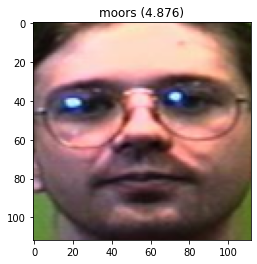

In [11]:

from random import choice
from numpy import load
from numpy import expand_dims
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.svm import SVC
from matplotlib import pyplot
# load faces
data = load('ArcFace+RetinaFace+Faces96+Lengkap100.npz')
testX_faces = data['arr_2']
# load face embeddings
data = load('ArcFace+RetinaFace+Faces96+Lengkap100_embeddings.npz')
trainX, trainy, testX, testy, valX,valy, timeX,timey = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3'], data['arr_4'], data['arr_5'], data['arr_6'], data['arr_7']
# normalize input vectors
in_encoder = Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)
# label encode targets
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)
# fit model
model = SVC(kernel='linear', probability=True)
model.fit(trainX, trainy)
# test model on a random example from the test dataset
selection = choice([i for i in range(testX.shape[0])])
random_face_pixels = testX_faces[selection]
random_face_emb = testX[selection]
random_face_class = testy[selection]
random_face_name = out_encoder.inverse_transform([random_face_class])
# prediction for the face
samples = expand_dims(random_face_emb, axis=0)
yhat_class = model.predict(samples)
yhat_prob = model.predict_proba(samples)
# get name
class_index = yhat_class[0]
class_probability = yhat_prob[0,class_index] * 100
predict_names = out_encoder.inverse_transform(yhat_class)
print('Predicted: %s (%.3f)' % (predict_names[0], class_probability))
print('Expected: %s' % random_face_name[0])
#plot
pyplot.imshow(random_face_pixels)
title = '%s (%.3f)' % (predict_names[0], class_probability)
pyplot.title(title)
pyplot.show()